In [1]:
import os
from contextlib import suppress

from tqdm.auto import tqdm

import distiller # required for quantization

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

from errno import ENOENT

import max78_modules.ai8x as ai8x

%matplotlib inline

# Setup device

In [2]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=False)
ai8x.set_device(87, simulate=False, round_avg=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Configuring device: MAX78002, simulate=False.


# Setup MNIST dataset and dataloader

In [3]:
transform_train = transforms.Compose([
        transforms.ToTensor(),                  # Convert PIL Image to PyTorch Tensor
        # add custom augmentations here
        transforms.RandomRotation(degrees=15),  # example, random rotation
        ai8x.normalize(args = args),            # normalize input to [-1, 1]
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),                  # Convert PIL Image to PyTorch Tensor
        ai8x.normalize(args = args),            # normalize input to [-1, 1]
    ])

In [4]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

batch_size = 64
dataset_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

dataset_labels = list(mnist_train.class_to_idx.values())

  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|██████████| 9912422/9912422 [00:00<00:00, 76672164.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 1648877/1648877 [00:00<00:00, 42081800.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 26681412.84it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Create classifier model

In [5]:
class ImageClassifierMax78002(nn.Module):
    def __init__(self, num_classes, bias=True, **kwargs):
        super(ImageClassifierMax78002, self).__init__()
        self.step1 = ai8x.FusedConv2dBNReLU(1, 32, 3, stride=1, padding=1, bias=bias, **kwargs)
        self.step2 = ai8x.FusedMaxPoolConv2dReLU(32, 64, 3, stride=1, padding=1, bias=bias, **kwargs)
        self.step3 = ai8x.FusedMaxPoolConv2dReLU(64, 96, 3, stride=1, padding=1, bias=bias, **kwargs)
        self.pool3 = ai8x.MaxPool2d(3, stride=2, padding=1)
        self.fc1 = ai8x.FusedLinearReLU(96 * 3 * 3, 256, bias=bias, **kwargs)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = ai8x.Linear(256, num_classes, bias=bias, **kwargs)
    
    def forward(self, x):
        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
NUM_CLASSES = 10
model = ImageClassifierMax78002(NUM_CLASSES)

# Define loss function and optimizer

In [7]:
compression_scheduler = distiller.CompressionScheduler(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=2, min_lr=1e-7)
criterion = nn.CrossEntropyLoss()

qat_policy = { 'weight_bits': 8 }
vloss = 10**6
steps_per_epoch = (len(dataset_train.sampler) + batch_size - 1)

# Train the model

In [8]:
# Define the number of training epochs
num_epochs = 7      # FP training epochs
num_epochs_qat = 3  # QAT training epochs


Epoch [1/7] - Loss: 0.9544 - Train Accuracy: 93.35%
Epoch [1/7] - Test Accuracy: 98.83%


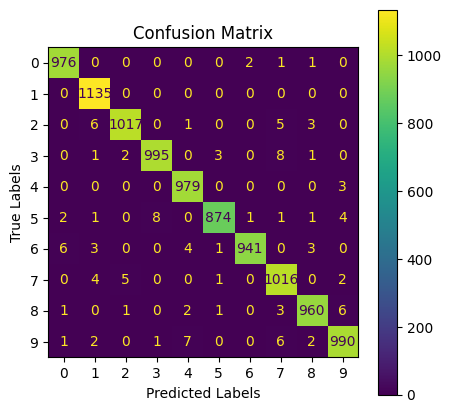


Epoch [2/7] - Loss: 0.8464 - Train Accuracy: 97.87%
Epoch [2/7] - Test Accuracy: 98.97%


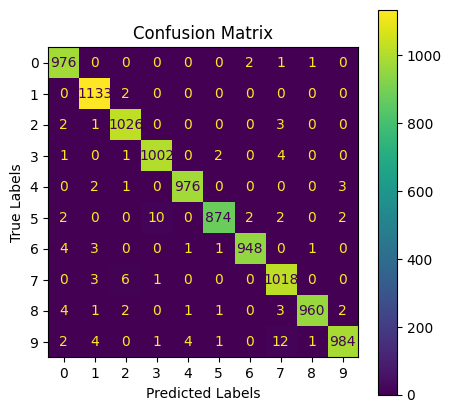


Epoch [3/7] - Loss: 0.8413 - Train Accuracy: 98.11%
Epoch [3/7] - Test Accuracy: 99.21%


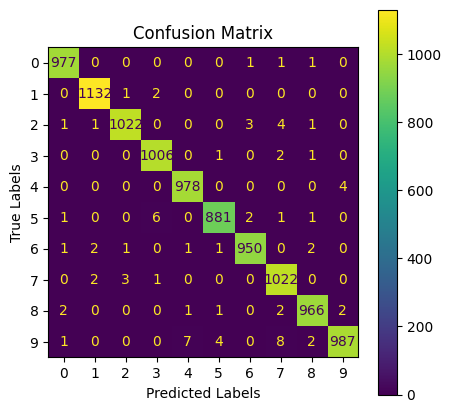


Epoch [4/7] - Loss: 0.8368 - Train Accuracy: 98.26%
Epoch [4/7] - Test Accuracy: 99.11%


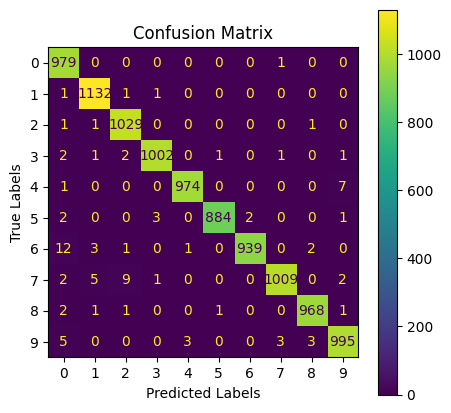


Epoch [5/7] - Loss: 0.8346 - Train Accuracy: 98.33%
Epoch [5/7] - Test Accuracy: 99.37%


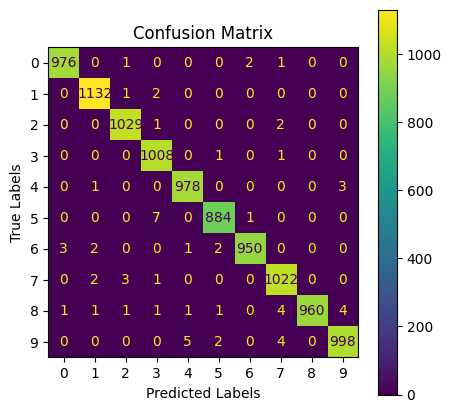


Epoch [6/7] - Loss: 0.8328 - Train Accuracy: 98.45%
Epoch [6/7] - Test Accuracy: 99.34%


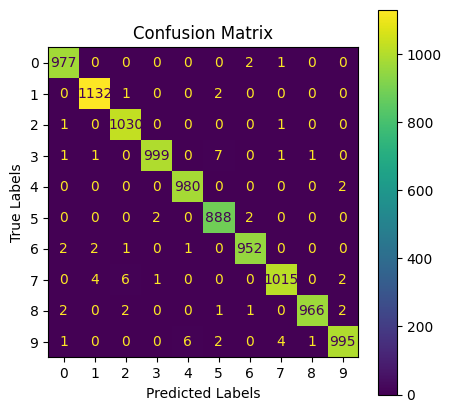


Epoch [7/7] - Loss: 0.8332 - Train Accuracy: 98.39%
Epoch [7/7] - Test Accuracy: 99.09%


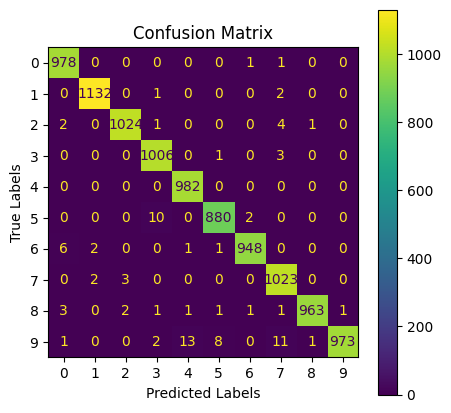

Moving model to QAT!



Epoch [8/7] - Loss: 0.8316 - Train Accuracy: 98.49%
Epoch [8/7] - Test Accuracy: 99.24%


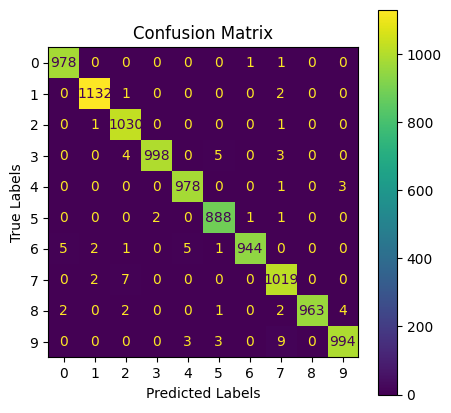


Epoch [9/7] - Loss: 0.8200 - Train Accuracy: 99.05%
Epoch [9/7] - Test Accuracy: 99.43%


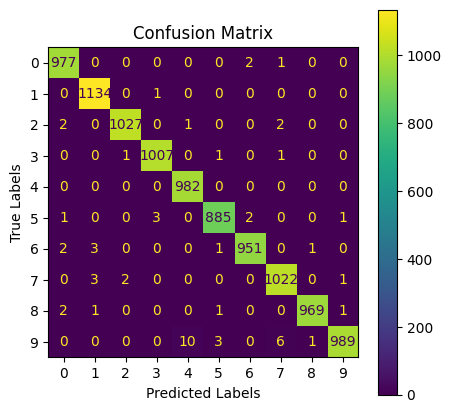


Epoch [10/7] - Loss: 0.8196 - Train Accuracy: 99.14%
Epoch [10/7] - Test Accuracy: 99.50%


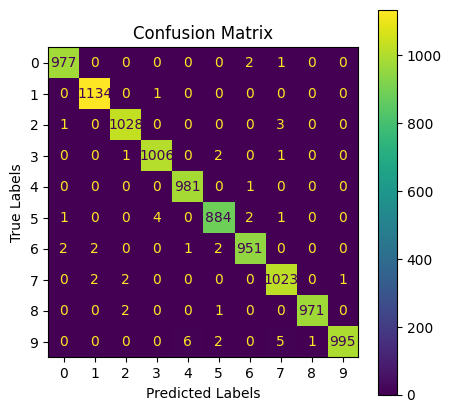

Training finished.


In [9]:
for epoch in range(num_epochs+num_epochs_qat):
    if epoch == num_epochs:
        print("Moving model to QAT!")
        ai8x.fuse_bn_layers(model)
        ai8x.initiate_qat(model, qat_policy)
        compression_scheduler = distiller.CompressionScheduler(model)
        model.to(device)

    
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for the training loop
    with tqdm(dataset_train, desc=f'Epoch [{epoch + 1}/{num_epochs}]', unit='batch') as tqdm_loader:
        compression_scheduler.on_epoch_begin(epoch, metrics=vloss)
        for train_step, (inputs, labels) in enumerate(tqdm_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            compression_scheduler.on_minibatch_begin(epoch, train_step, steps_per_epoch, optimizer)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            compression_scheduler.before_backward_pass(epoch, train_step, steps_per_epoch, loss, optimizer=optimizer, return_loss_components=False)
            loss.backward()
            compression_scheduler.before_parameter_optimization(epoch, train_step, steps_per_epoch, optimizer)
            optimizer.step()
            compression_scheduler.on_minibatch_end(epoch, train_step, steps_per_epoch, optimizer)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update the tqdm progress bar
            tqdm_loader.set_postfix({'Loss': total_loss / (len(tqdm_loader) + 1), 'Accuracy': 100 * correct / total})
        compression_scheduler.on_epoch_end(epoch, optimizer)
    
    # Calculate and print training accuracy and loss for the current epoch
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(dataset_train):.4f} - Train Accuracy: {train_accuracy:.2f}%')
    
    # Evaluation loop (unchanged)
    model.eval()
    correct = 0
    total = 0

    true_labels = []  # Initialize lists to store true labels and predicted labels
    predicted_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataset_test:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true labels and predicted labels to the lists
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Calculate and print test accuracy for the current epoch
    test_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Accuracy: {test_accuracy:.2f}%')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Display the confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset_labels)
    fig, ax = plt.subplots(figsize=(5,5))
    display.plot(cmap='viridis', values_format='d', ax=ax)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    
    # Adjust learning rate using the scheduler based on test accuracy
    scheduler.step(test_accuracy)

# Training is complete
print('Training finished.')

# Generate sample for the KAT

In [ ]:
# Select which sample to use from the first batch (0-63)
sample_index = 0

x, y = next(iter(dataset_test))
kat_image = (x[sample_index].numpy()*128).astype(np.int64)
kat_image = np.clip(kat_image, -128, 127)
print(f"Sample {sample_index}: Label = {y[sample_index].item()}")

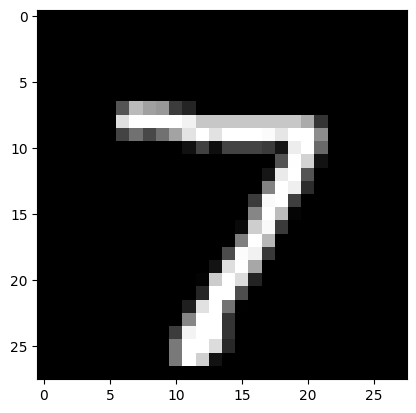

In [11]:
plt.imshow(kat_image[0], cmap='gray', vmin=-128, vmax=127)

In [12]:
np.save('sample_mnist_2828.npy', kat_image, allow_pickle=False, fix_imports=False)

# Save the model checkpoint (compatible with the synthesizer)

In [13]:
def save_checkpoint_custom(epoch, arch, model, optimizer=None, scheduler=None, extras=None, name=None, dir='.'):
    """Save a pytorch training checkpoint

    Args:
        epoch: current epoch number
        arch: name of the network architecture/topology
        model: a pytorch model
        optimizer: the optimizer used in the training session
        scheduler: the CompressionScheduler instance used for training, if any
        extras: optional dict with additional user-defined data to be saved in the checkpoint.
            Will be saved under the key 'extras'
        name: the name of the checkpoint file
        dir: directory in which to save the checkpoint
    """
    if not os.path.isdir(dir):
        raise IOError(ENOENT, 'Checkpoint directory does not exist at', os.path.abspath(dir))

    if extras is None:
        extras = {}
    if not isinstance(extras, dict):
        raise TypeError('extras must be either a dict or None')

    filename = 'checkpoint.pth.tar' if name is None else name + '_checkpoint.pth.tar'
    fullpath = os.path.join(dir, filename)
    print("Saving checkpoint to: %s" % fullpath)

    checkpoint = {'epoch': epoch, 'state_dict': model.state_dict(), 'arch': arch}
    with suppress(AttributeError):
        checkpoint['is_parallel'] = model.is_parallel
        checkpoint['dataset'] = model.dataset
        if not arch:
            checkpoint['arch'] = model.arch

    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        checkpoint['optimizer_type'] = type(optimizer)
    if scheduler is not None:
        checkpoint['compression_sched'] = scheduler.state_dict()
    if hasattr(model, 'thinning_recipes'):
        checkpoint['thinning_recipes'] = model.thinning_recipes
    if hasattr(model, 'quantizer_metadata'):
        checkpoint['quantizer_metadata'] = model.quantizer_metadata

    checkpoint['extras'] = extras
    torch.save(checkpoint, fullpath)

In [14]:
save_checkpoint_custom(num_epochs, "ai87net-mnist-classifier", model, optimizer, scheduler, None, "qat_class_mnist", './')

Saving checkpoint to: ./qat_class_mnist_checkpoint.pth.tar
